# Notebook for LSTM - Model Testing

Different layersizes, number of layers and epochs were tested and evaluated in this notebook.
The resulting models were all saved, the best one is used for the website

the notebooks RNN all lemma and RNN no party contain similar test, only difference: There an all-lemma-/no-party-matrix was used instead of the "vector_all_data_300d-3-5" matrix

In [1]:
# imports
import csv
import numpy as np
import pandas as pd
import import_ipynb
import spacy
from sklearn.model_selection import train_test_split
from tqdm import tqdm

nlp = spacy.load(
    "de_core_news_lg", exclude=["tok2vec", "ner", "parser", "attribute_ruler"]
)
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import make_sampling_table, pad_sequences
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import (
    Dot,
    Embedding,
    Flatten,
    Dense,
    GlobalAveragePooling1D,
    LSTM,
    concatenate,
    Dropout,
    Bidirectional,
)
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [105]:
# Deep learning Model 1

class RnnModel():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        # imput = padded sequence
        inp1 = Input(shape=(max_len,))
        # embedding layer: loads the word vector from the embedding matrix
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        # bi-directional lstm-layer
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64))(x)
        #densely connected layer with Rectified Linear Unit (relu) activation and 10% dropout
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.1)(x)
        #densely connected layer
        x = Dense(64, activation="relu")(x)
        # layer with the predictions
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model


In [2]:
#data
data = pd.DataFrame(columns=['tweet', 'party'])

afd = pd.read_csv('../cleaned-data/AfD.csv', quoting=csv.QUOTE_NONE)['text']
afd = pd.DataFrame([[i, 0] for i in afd], columns=['tweet', 'party'])

data = data.append(afd, ignore_index=True)

cdu = pd.read_csv('../cleaned-data/CDU.csv',quoting=csv.QUOTE_NONE)['text']
csu = pd.read_csv('../cleaned-data/CSU.csv',quoting=csv.QUOTE_NONE)['text']

cdu = pd.DataFrame([[i, 1] for i in cdu], columns=['tweet', 'party'])
csu = pd.DataFrame([[i, 1] for i in csu], columns=['tweet', 'party'])

data = data.append(cdu, ignore_index=True)
data = data.append(csu, ignore_index=True)

fdp = pd.read_csv('../cleaned-data/FDP.csv',quoting=csv.QUOTE_NONE)['text']
fdp = pd.DataFrame([[i, 2] for i in fdp], columns=['tweet', 'party'])

data = data.append(fdp, ignore_index=True)

gru = pd.read_csv('../cleaned-data/GRÜNE.csv',quoting=csv.QUOTE_NONE)['text']
gru = pd.DataFrame([[i, 3] for i in gru], columns=['tweet', 'party'])

data = data.append(gru, ignore_index=True)

lin = pd.read_csv('../cleaned-data/LINKE.csv',quoting=csv.QUOTE_NONE)['text']
lin = pd.DataFrame([[i, 4] for i in lin], columns=['tweet', 'party'])

data = data.append(lin, ignore_index=True)

spd = pd.read_csv('../cleaned-data/SPD.csv',quoting=csv.QUOTE_NONE)['text']
spd = pd.DataFrame([[i, 5] for i in spd], columns=['tweet', 'party'])

data = data.append(spd, ignore_index=True)
data = data.dropna()

In [3]:
# loading vocab and embedding matrix
words = []
em_matrix = np.genfromtxt(fname = "../word_embedding/embeddings/vector_all_data_300d-3-5.tsv", delimiter = "\t" )       
with open("../vocab/all_vocab_token.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader) #skip header
    vocab = {rows[0]:int(rows[2]) for rows in reader}
# adding unknown token for new words
vocab['UNK'] = len(vocab)

In [4]:
# transforming data
# 1.) tokenizing
# 2.) padding to length 50
data['vectors'] = data['tweet'].apply([lambda x: [vocab[y.text] if y.text in vocab else vocab['UNK'] for y in nlp(str(x))]])
data['vectors'] = data['vectors'].apply(lambda x: pad_sequences([x], maxlen=50, dtype=int, padding='post',value=0)[-1])
data['len'] = data['vectors'].apply(lambda x: len(x))
data_len = data['len'].max()
data

,tweet,party,vectors,len
0,Teenie auf dem Weg nach Malle Nein Aussenminis...,0,"[36532, 16, 35, 298, 61, 45006, 205, 1516, 16,...",50
1,Heute Abend bin ich gemeinsam mit user zu Gast...,0,"[132, 405, 146, 21, 382, 13, 1, 9, 1253, 123, ...",50
2,Berlin 17 Grad Die Frisur passt Unsere Motivat...,0,"[104, 1012, 2703, 18, 11988, 865, 523, 5806, 1...",50
3,Lieber user lieber user ich gratuliere Ihnen h...,0,"[654, 1, 322, 1, 21, 4066, 228, 2088, 56, 1776...",50
4,Seit gestern koennen die Mitglieder unserer Af...,0,"[580, 444, 101, 2, 922, 236, 46, 464, 3936, 25...",50
...,...,...,...,...
306944,user Danke,5,"[1, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",50
306945,Herzlich Willkommen in der SPD Seit gestern Ab...,5,"[3516, 2406, 5, 3, 95, 580, 444, 405, 30, 1282...",50
306946,Hatte 4 gute Jahre als Vors SPD BTF Freue mich...,5,"[2357, 265, 211, 209, 33, 20018, 95, 75077, 69...",50
306947,Glueckwunsch an Nils Annen,5,"[182, 27, 18470, 45896, 0, 0, 0, 0, 0, 0, 0, 0...",50


In [ ]:
# preparing label: transforming integer to vector
y = tf.keras.utils.to_categorical(data['party'].to_numpy())
y
# preparing data (dataframe to np.array) 
X = np.array([np.array(x) for x in data['vectors']])
X

In [ ]:
# splitting into train/test/validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4)

In [31]:
# 1. Test of model 1
m = RnnModel(em_matrix, 300, 50)
h = m.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 536s 1s/step - loss: 0.4003 - accuracy: 0.3577 - val_loss: 0.3509 - val_accuracy: 0.4601
Epoch 2/5
476/476 [==============================] - 517s 1s/step - loss: 0.3160 - accuracy: 0.5355 - val_loss: 0.3149 - val_accuracy: 0.5330
Epoch 3/5
476/476 [==============================] - 519s 1s/step - loss: 0.2642 - accuracy: 0.6273 - val_loss: 0.3110 - val_accuracy: 0.5567
Epoch 4/5
476/476 [==============================] - 514s 1s/step - loss: 0.2240 - accuracy: 0.6899 - val_loss: 0.3223 - val_accuracy: 0.5625
Epoch 5/5
476/476 [==============================] - 509s 1s/step - loss: 0.1920 - accuracy: 0.7367 - val_loss: 0.3565 - val_accuracy: 0.5606


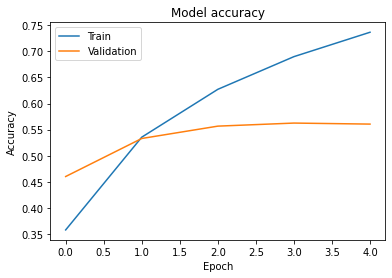

In [34]:
# Evaluation for test 1
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

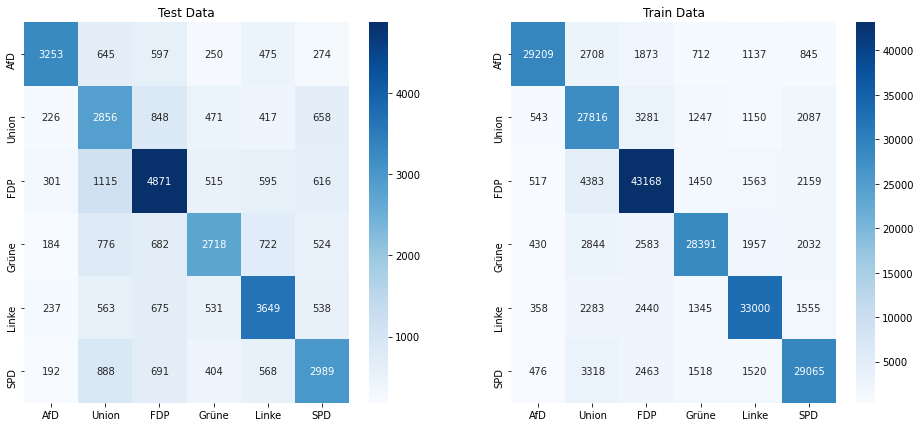

Party: 	 Test 	 Train
Afd:	 5494 	 36484
Union:	 5476 	 36124
FDP:	 8013 	 53240
Grüne:	 5606 	 38237
Linke:	 6193 	 40981
SPD:	 5732 	 38360

Acc:	 55.69% 78.32%


In [37]:
model = m.model
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');


# Block to evaluate test data
yhat_train = model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [38]:
# testing of saving and reloading weights
model.save_weights("test_trail/my_weights_all_data_1")

In [39]:
# testing of saving and reloading weights
loaded = RnnModel(em_matrix, 300, 50)
loaded.model.load_weights("test_trail/my_weights_all_data_1")

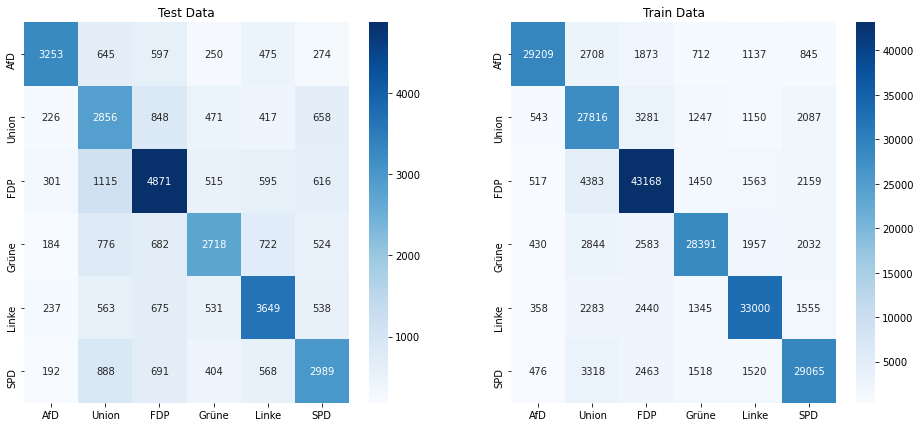

Party: 	 Test 	 Train
Afd:	 5494 	 36484
Union:	 5476 	 36124
FDP:	 8013 	 53240
Grüne:	 5606 	 38237
Linke:	 6193 	 40981
SPD:	 5732 	 38360

Acc:	 55.69% 78.32%


In [41]:
#re-evaluation of loaded model
l = loaded.model
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = l.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');


# Block to evaluate test data
yhat_train = l.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [42]:
# 2. Model (see first model)
class RnnModel2():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(256, return_sequences=True))(x)
        x = Bidirectional(LSTM(128))(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model

In [44]:
#testing 2. model
m2 = RnnModel2(em_matrix, 300, 50)
h2 = m2.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 944s 2s/step - loss: 0.3921 - accuracy: 0.3739 - val_loss: 0.3460 - val_accuracy: 0.4746
Epoch 2/5
476/476 [==============================] - 920s 2s/step - loss: 0.3117 - accuracy: 0.5428 - val_loss: 0.3134 - val_accuracy: 0.5402
Epoch 3/5
476/476 [==============================] - 905s 2s/step - loss: 0.2613 - accuracy: 0.6311 - val_loss: 0.3109 - val_accuracy: 0.5598
Epoch 4/5
476/476 [==============================] - 920s 2s/step - loss: 0.2218 - accuracy: 0.6933 - val_loss: 0.3251 - val_accuracy: 0.5582
Epoch 5/5
476/476 [==============================] - 908s 2s/step - loss: 0.1885 - accuracy: 0.7414 - val_loss: 0.3487 - val_accuracy: 0.5666


In [48]:
# testing first model with more epochs
m3 = RnnModel(em_matrix, 300, 50)
h3 = m3.model.fit(X_train, y_train, epochs = 10, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/10
476/476 [==============================] - 554s 1s/step - loss: 0.4026 - accuracy: 0.3540 - val_loss: 0.3563 - val_accuracy: 0.4504
Epoch 2/10
476/476 [==============================] - 510s 1s/step - loss: 0.3215 - accuracy: 0.5242 - val_loss: 0.3224 - val_accuracy: 0.5324
Epoch 3/10
476/476 [==============================] - 563s 1s/step - loss: 0.2683 - accuracy: 0.6197 - val_loss: 0.3120 - val_accuracy: 0.5538
Epoch 4/10
476/476 [==============================] - 564s 1s/step - loss: 0.2281 - accuracy: 0.6833 - val_loss: 0.3265 - val_accuracy: 0.5612
Epoch 5/10
476/476 [==============================] - 563s 1s/step - loss: 0.1962 - accuracy: 0.7305 - val_loss: 0.3494 - val_accuracy: 0.5619
Epoch 6/10
476/476 [==============================] - 558s 1s/step - loss: 0.1702 - accuracy: 0.7656 - val_loss: 0.3805 - val_accuracy: 0.5578
Epoch 7/10
476/476 [==============================] - 569s 1s/step - loss: 0.1487 - accuracy: 0.7954 - val_loss: 0.4249 - val_accuracy: 0.5574

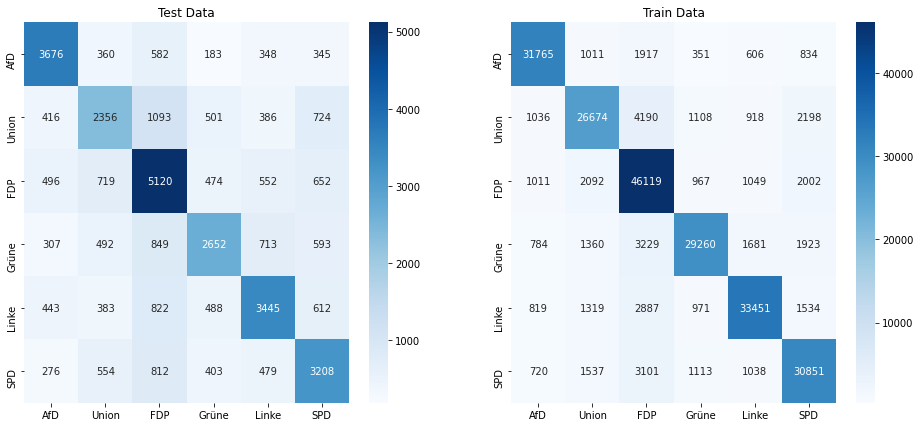

Party: 	 Test 	 Train
Afd:	 5494 	 36484
Union:	 5476 	 36124
FDP:	 8013 	 53240
Grüne:	 5606 	 38237
Linke:	 6193 	 40981
SPD:	 5732 	 38360

Acc:	 56.03% 81.39%


In [47]:
# evaluation of 2nd test
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m2.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');


# Block to evaluate test data
yhat_train = m2.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

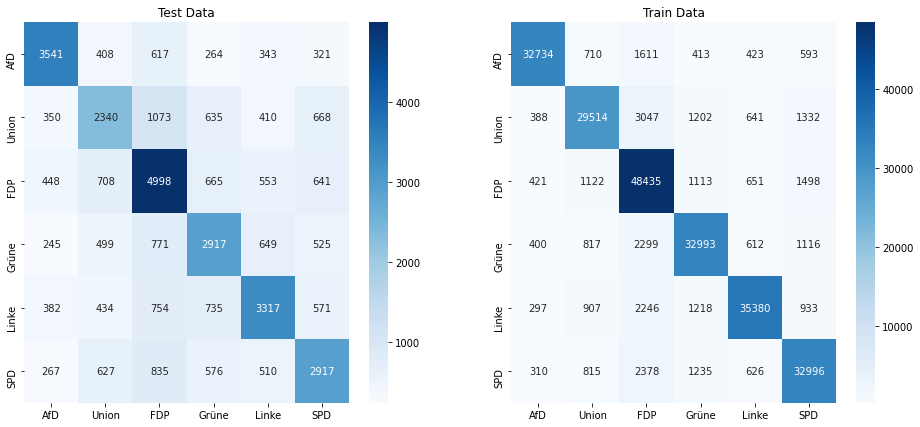

Party: 	 Test 	 Train
Afd:	 5494 	 36484
Union:	 5476 	 36124
FDP:	 8013 	 53240
Grüne:	 5606 	 38237
Linke:	 6193 	 40981
SPD:	 5732 	 38360

Acc:	 54.86% 87.11%


In [49]:
# evaluation of 3nd test
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m3.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');


# Block to evaluate test data
yhat_train = m3.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

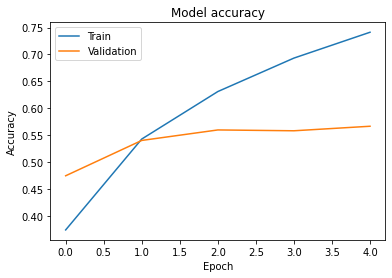

In [50]:
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

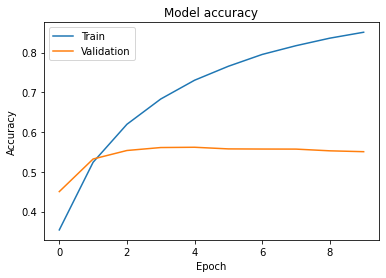

In [51]:
plt.plot(h3.history['accuracy'])
plt.plot(h3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [52]:
# 3. Model
class RnnModel3():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64))(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model

In [53]:
# 4. Test: 3. Model with 5 epochs
m4 = RnnModel3(em_matrix, 300, 50)
h4 = m4.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 514s 1s/step - loss: 0.4038 - accuracy: 0.3487 - val_loss: 0.3544 - val_accuracy: 0.4520
Epoch 2/5
476/476 [==============================] - 488s 1s/step - loss: 0.3233 - accuracy: 0.5185 - val_loss: 0.3199 - val_accuracy: 0.5261
Epoch 3/5
476/476 [==============================] - 488s 1s/step - loss: 0.2722 - accuracy: 0.6127 - val_loss: 0.3142 - val_accuracy: 0.5515
Epoch 4/5
476/476 [==============================] - 488s 1s/step - loss: 0.2324 - accuracy: 0.6762 - val_loss: 0.3286 - val_accuracy: 0.5586
Epoch 5/5
476/476 [==============================] - 489s 1s/step - loss: 0.1998 - accuracy: 0.7243 - val_loss: 0.3513 - val_accuracy: 0.5568


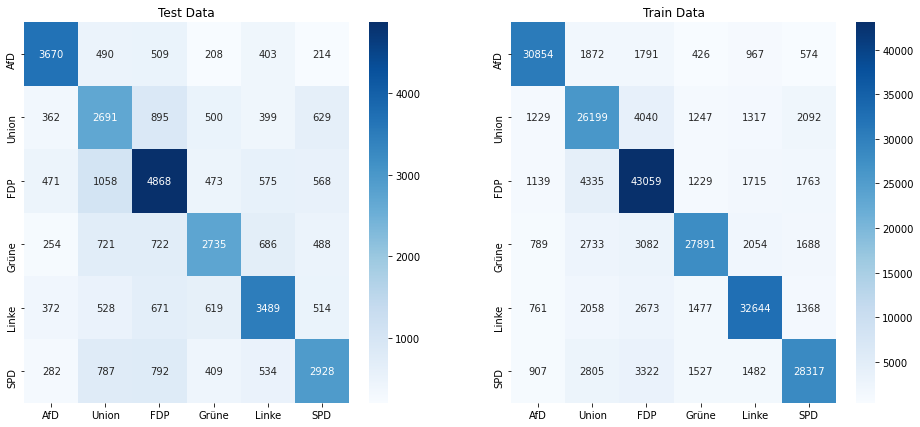

Party: 	 Test 	 Train
Afd:	 5494 	 36484
Union:	 5476 	 36124
FDP:	 8013 	 53240
Grüne:	 5606 	 38237
Linke:	 6193 	 40981
SPD:	 5732 	 38360

Acc:	 55.82% 77.63%


In [54]:
# Eval of 4. Test
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m4.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');


# Block to evaluate test data
yhat_train = m4.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [55]:
# 4. Model
class RnnModel4():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64))(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(128, activation="relu")(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model

In [56]:
# 5. Test: 4. Model with 5 epochs
m5 = RnnModel4(em_matrix, 300, 50)
h5 = m5.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 574s 1s/step - loss: 0.4097 - accuracy: 0.3357 - val_loss: 0.3594 - val_accuracy: 0.4443
Epoch 2/5
476/476 [==============================] - 578s 1s/step - loss: 0.3266 - accuracy: 0.5106 - val_loss: 0.3181 - val_accuracy: 0.5305
Epoch 3/5
476/476 [==============================] - 595s 1s/step - loss: 0.2724 - accuracy: 0.6122 - val_loss: 0.3147 - val_accuracy: 0.5508
Epoch 4/5
476/476 [==============================] - 569s 1s/step - loss: 0.2310 - accuracy: 0.6786 - val_loss: 0.3178 - val_accuracy: 0.5631
Epoch 5/5
476/476 [==============================] - 543s 1s/step - loss: 0.1973 - accuracy: 0.7277 - val_loss: 0.3477 - val_accuracy: 0.5603


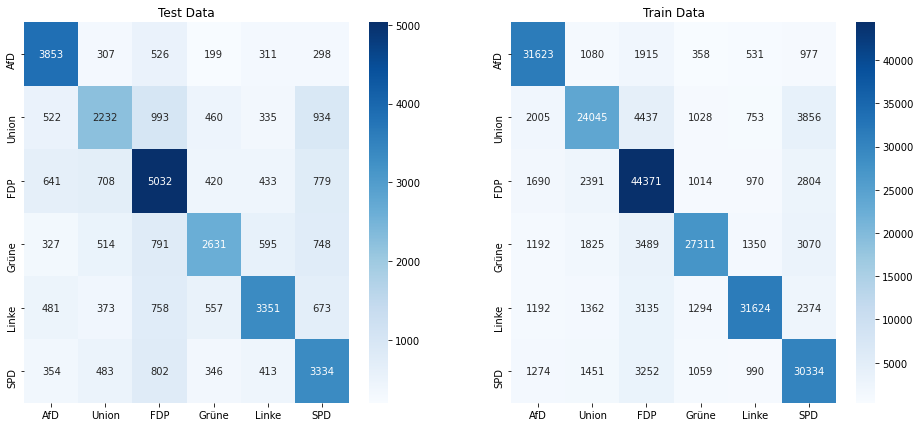

Party: 	 Test 	 Train
Afd:	 5494 	 36484
Union:	 5476 	 36124
FDP:	 8013 	 53240
Grüne:	 5606 	 38237
Linke:	 6193 	 40981
SPD:	 5732 	 38360

Acc:	 55.96% 77.77%


In [57]:
#eval of 5. test
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m5.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');


# Block to evaluate test data
yhat_train = m5.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [117]:
# saving model plot
for c,mode in enumerate([m,m2,m4,m5]):
    plot_model(mode.model, to_file='models/Rnn' + str(c) + '.png', show_shapes = True)


In [78]:
# saving weights of all models
models = [m, m2, m3, m4, m5]
histories = [h, h2, h3, h4, h5]
Model = ["Rnn", "Rnn2", "Rnn", "Rnn3", "Rnn4"]
ep = [5, 5, 10, 5, 5]


for ct, hx in enumerate(histories):
    S = "{mod}_ep{epo}_acc{acc}_valacc{valacc}".format(
        mod=Model[ct],
        epo=ep[ct],
        acc="{:2.2f}".format(hx.history["accuracy"][-1] * 100),
        valacc="{:2.2f}".format(hx.history["val_accuracy"][-1]*100),
    )
    models[ct].model.save_weights('models/'+S+'/model_weights')
    
    

In [108]:
# 5. Model 
class RnnModel5():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(512, return_sequences=True))(x)
        x = Bidirectional(LSTM(256))(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(256, activation="relu")(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model

In [110]:
# test 6: Model 5 with 5 epochs
m6 = RnnModel5(em_matrix, 300, 50)
h6 = m6.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 1975s 4s/step - loss: 0.3993 - accuracy: 0.3571 - val_loss: 0.3575 - val_accuracy: 0.4478
Epoch 2/5
476/476 [==============================] - 2045s 4s/step - loss: 0.3201 - accuracy: 0.5253 - val_loss: 0.3147 - val_accuracy: 0.5406
Epoch 3/5
476/476 [==============================] - 2198s 5s/step - loss: 0.2687 - accuracy: 0.6181 - val_loss: 0.3082 - val_accuracy: 0.5540
Epoch 4/5
476/476 [==============================] - 2165s 5s/step - loss: 0.2279 - accuracy: 0.6833 - val_loss: 0.3142 - val_accuracy: 0.5644
Epoch 5/5
476/476 [==============================] - 1969s 4s/step - loss: 0.1919 - accuracy: 0.7353 - val_loss: 0.3438 - val_accuracy: 0.5680


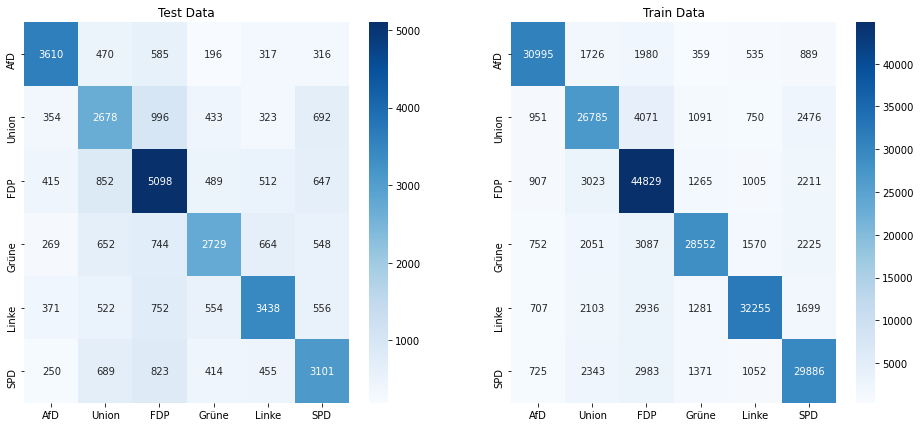

Party: 	 Test 	 Train
Afd:	 5494 	 36484
Union:	 5476 	 36124
FDP:	 8013 	 53240
Grüne:	 5606 	 38237
Linke:	 6193 	 40981
SPD:	 5732 	 38360

Acc:	 56.56% 79.41%


In [111]:
# eval of test 6
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m6.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');


# Block to evaluate test data
yhat_train = m6.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

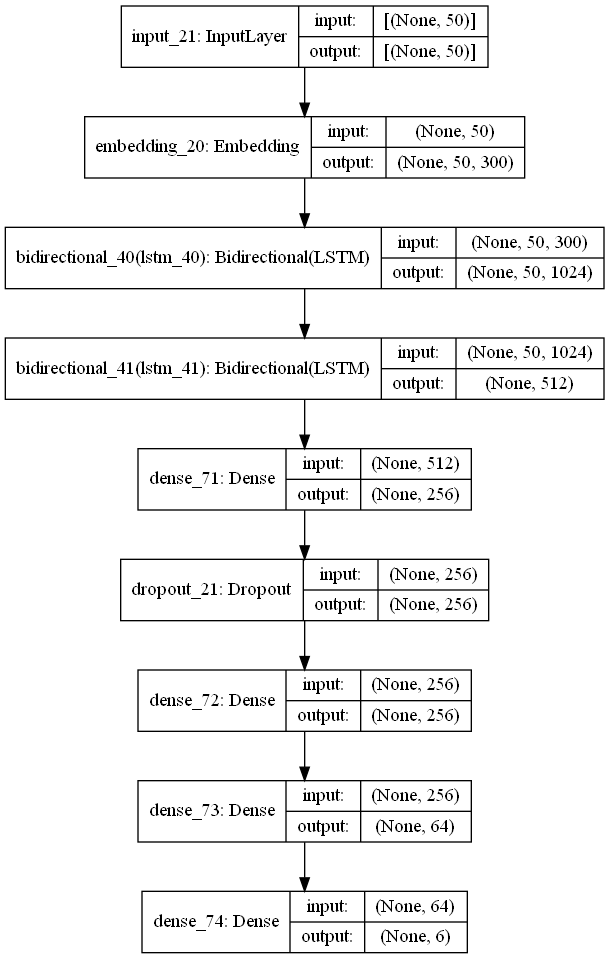

In [116]:
#model-plot for test 6
plot_model(m6.model, to_file='models/Rnn' + '5' + '.png', show_shapes=True)

In [115]:
#saving test 6
S = "{mod}_ep{epo}_acc{acc}_valacc{valacc}".format(
        mod='Rnn5',
        epo=5,
        acc="{:2.2f}".format(h6.history["accuracy"][-1] * 100),
        valacc="{:2.2f}".format(h6.history["val_accuracy"][-1]*100),
    )
m6.model.save_weights('models/'+S+'/model_weights')

In [119]:
#validating saved data
m7 = RnnModel5(em_matrix, 300, 50)
m7.model.load_weights("models/Rnn5_ep5_acc73.53_valacc56.80/model_weights")

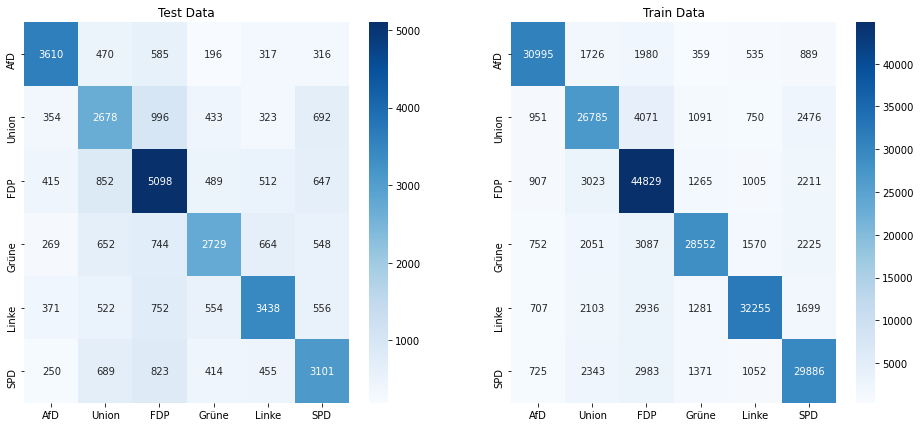

Party: 	 Test 	 Train
Afd:	 5494 	 36484
Union:	 5476 	 36124
FDP:	 8013 	 53240
Grüne:	 5606 	 38237
Linke:	 6193 	 40981
SPD:	 5732 	 38360

Acc:	 56.56% 79.41%


In [121]:
# reevaluation test 6 after reload
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m7.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');


# Block to evaluate test data
yhat_train = m7.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [8]:
# compact version for website
# contains:
# loading of matrix
# creation of model class
# loading of model weights
em_matrix = np.genfromtxt(fname = "../word_embedding/embeddings/vector_all_data_300d-3-5.tsv", delimiter = "\t" )
class RnnModel2():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(256, return_sequences=True))(x)
        x = Bidirectional(LSTM(128))(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model
        
        
loaded = RnnModel2(em_matrix, 300, 50)
loaded.model.load_weights("models/Rnn5_ep5_acc73.53_valacc56.80/model_weights")